In [1]:
import pykoop
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import seaborn as sns
import sklearn
from res_tool import plot_main, plot_clustered_kuramoto

# 数据生成

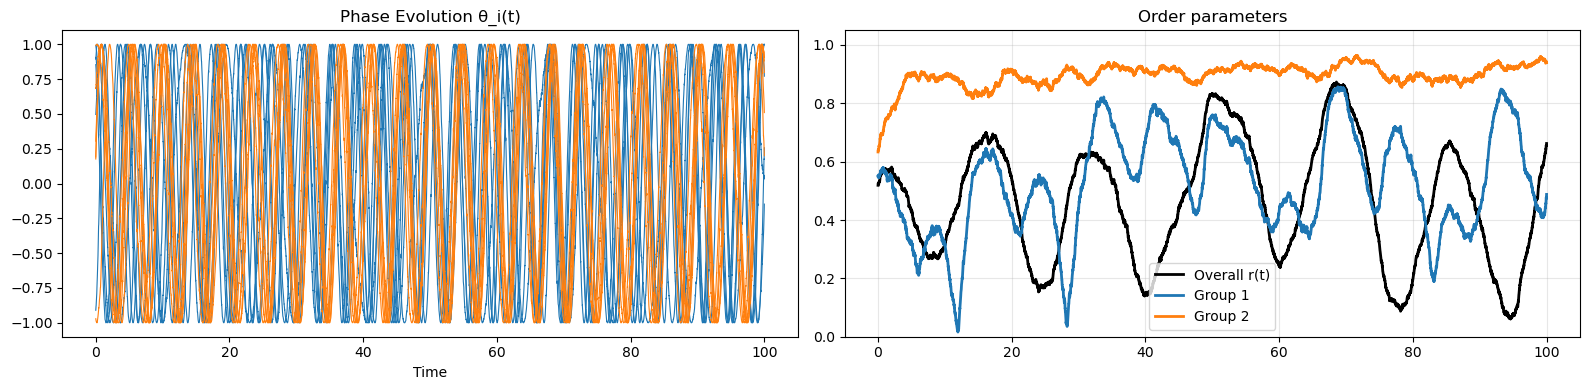

In [2]:
N=12
X_embed, K_matrix = plot_clustered_kuramoto(
    N=N,          # 振子数
    n_clusters=2,  # 团数
    K_intra=1,   # 团内耦合
    K_inter=0.1,   # 团间耦合
    noise=0.01,
    T=100
)


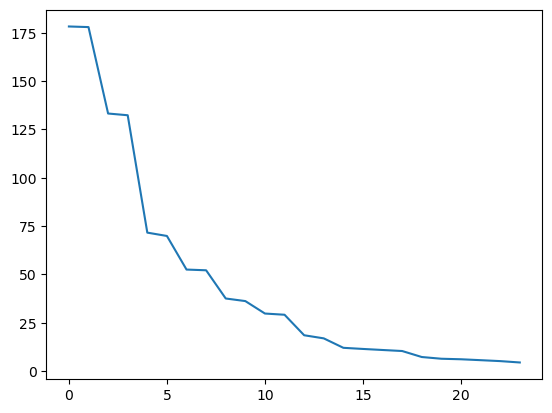

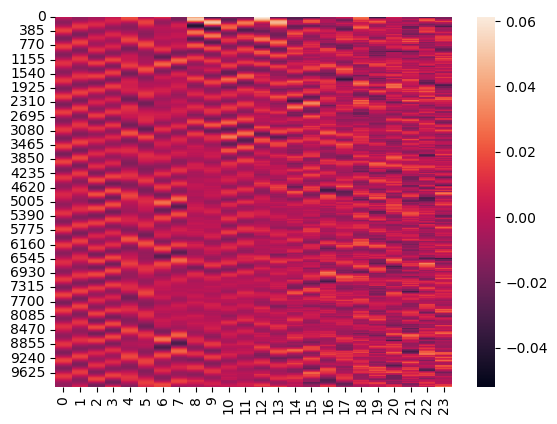

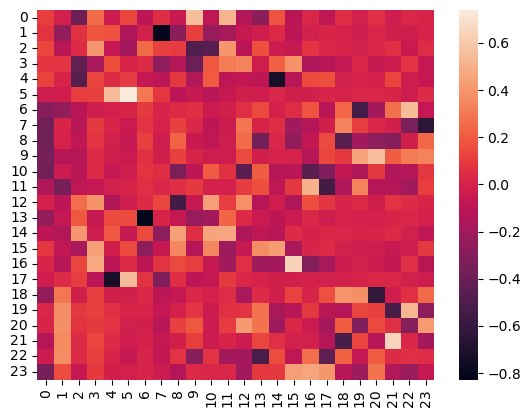

In [412]:
tsvd = pykoop.Tsvd() #truncation='rank',truncation_param=8
tsvd.fit(X_embed)
plt.plot(tsvd.singular_values_)
plt.show()
sns.heatmap(tsvd.left_singular_vectors_)
plt.show()
sns.heatmap(tsvd.right_singular_vectors_)
plt.show()

# Koopman拟合

In [391]:
#多项式函数
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('pl', pykoop.PolynomialLiftingFn(order=1,interaction_only=True)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='unknown_noise')),#,truncation_param=20
)
# Fit the pipeline
kp.fit(
    X_embed,
    n_inputs=0
)
error = -kp.score(X_embed)
error

np.float64(0.14445328975495317)

In [398]:
# 径向基函数
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('rbf', pykoop.RbfLiftingFn(rbf='gaussian',centers=pykoop.ClusterCenters(estimator=sklearn.cluster.KMeans(n_clusters=24)),shape=1)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
)
# Fit the pipeline
kp.fit(
    X_embed,
    n_inputs=0
)
error = -kp.score(X_embed)
error

np.float64(0.1223092553168662)

In [427]:
#kernal，随机傅立叶表征
kp = pykoop.KoopmanPipeline(
    lifting_functions=[(
        'rff',
        pykoop.KernelApproxLiftingFn(
            kernel_approx=pykoop.RandomFourierKernelApprox(
                n_components=24,
                random_state=10,
            )),
    )],
    regressor=pykoop.Edmd(alpha=0.5),
)

kp.fit(
    X_embed,
    n_inputs=0
)
error = -kp.score(X_embed)
error

np.float64(0.10280936440326433)

In [335]:
#延迟嵌入，Hankel
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('delay', pykoop.DelayLiftingFn(n_delays_state=2)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='unknown_noise')),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='rank',truncation_param=4)),
)
# Fit the pipeline
kp.fit(
    X_embed,
    n_inputs=0
)
error = -kp.score(X_embed)
error


np.float64(0.08357105909849975)

# 真伪特征值

总特征值数量: 48
res阈值: 0.01
可靠特征值数量 (res <= 0.01): (2, [32, 33])
虚假特征值数量 (res > 0.01): 46
残差RES的范围：0.014144 ~ 0.239918


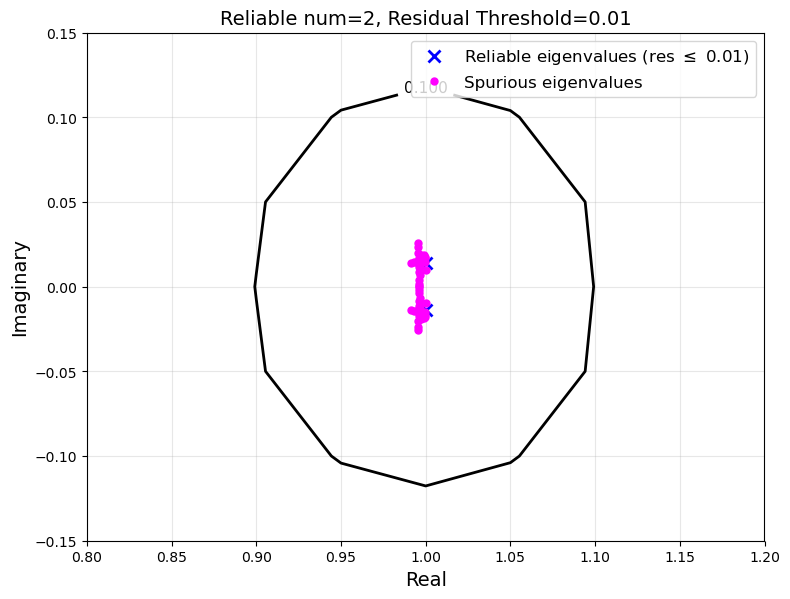

In [428]:
eigenvalues, residuals, reliable_indices = plot_main(kp, X_embed)

# 多步预测

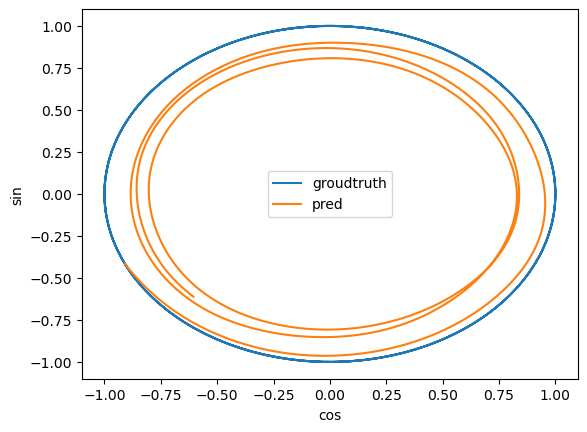

In [429]:
p_steps = 1000
X_test = X_embed[:p_steps,:]
pred = kp.predict_trajectory(X_test,None)
plt.figure()
plt.plot(X_test[:,0],X_test[:,N],label='groudtruth')
plt.plot(pred[:,0],pred[:,N],label='pred')
plt.xlabel('cos')
plt.ylabel('sin')
plt.legend()
plt.show()


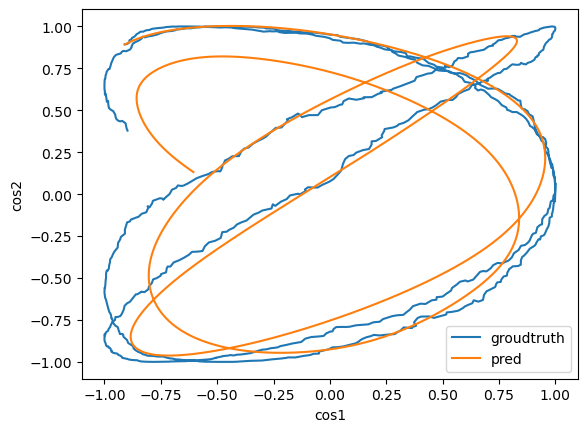

In [430]:
p_steps = 1000
X_test = X_embed[:p_steps,:]
pred = kp.predict_trajectory(X_test,None)
plt.figure()
plt.plot(X_test[:,0],X_test[:,1],label='groudtruth')
plt.plot(pred[:,0],pred[:,1],label='pred')
plt.xlabel('cos1')
plt.ylabel('cos2')
plt.legend()
plt.show()

# 特征谱与SVD分析

(<Figure size 640x480 with 2 Axes>, <Axes: >)

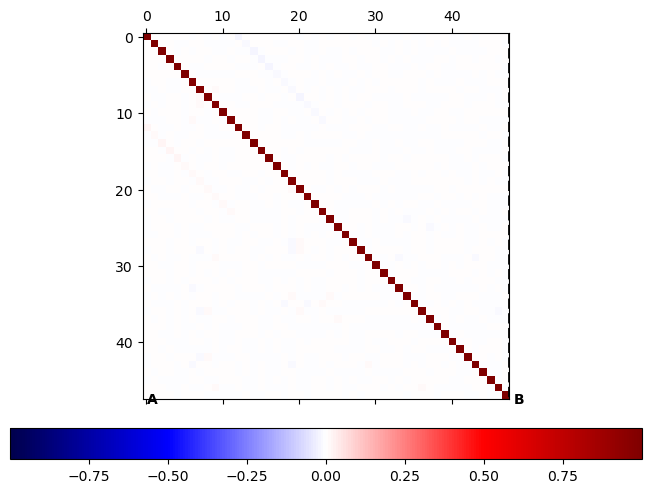

In [431]:
kp.regressor_.plot_koopman_matrix()

(48, 48)


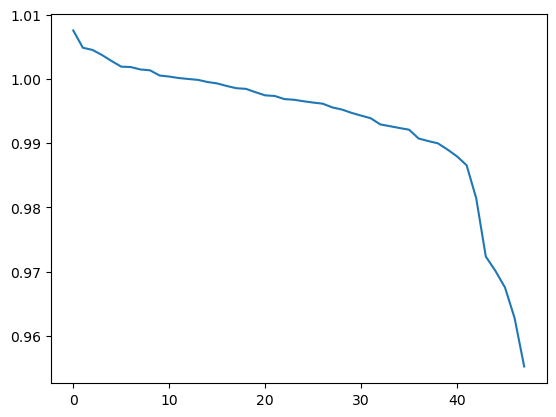

In [433]:
A = kp.regressor_.coef_
print(A.shape)
U,S,V = np.linalg.svd(A)
plt.figure()
plt.plot(S)
plt.show()

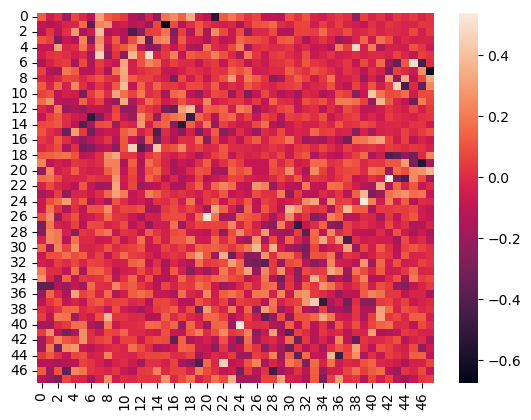

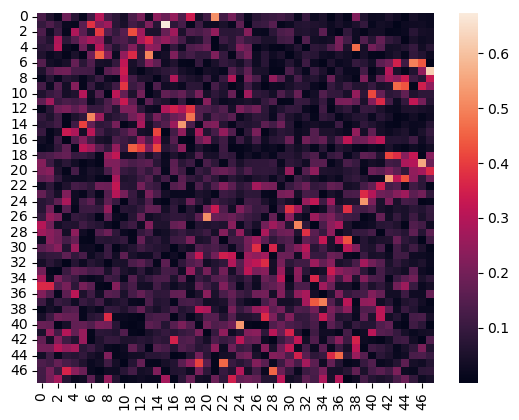

In [434]:
U_abs = np.abs(U)
plt.figure()
sns.heatmap(np.real(U))
plt.show()
plt.figure()
sns.heatmap(U_abs)
plt.show()

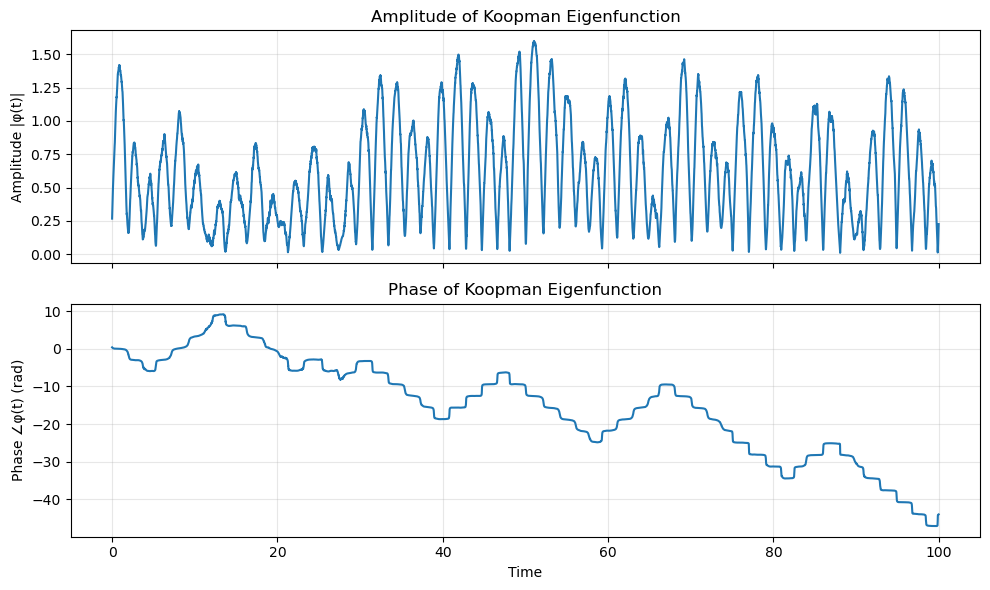

In [436]:
eig_val, left_vecs = np.linalg.eig(A.T)
eig_val, righ_vecs = np.linalg.eig(A)
phi = left_vecs @ kp.lift(X_embed).T

phi_to_plot = phi[0, :]

# 计算幅值和相位
amplitude = np.abs(phi_to_plot)
phase = np.angle(phi_to_plot)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6), sharex=True)

# 1. 绘制幅值
ax1.set_title("Amplitude of Koopman Eigenfunction")
ax1.plot(t, amplitude)
ax1.set_ylabel("Amplitude |φ(t)|")
ax1.grid(True, alpha=0.3)

# 2. 绘制相位 (需要处理跳变)
ax2.set_title("Phase of Koopman Eigenfunction")
ax2.plot(t, np.unwrap(phase)) # np.unwrap() 可以消除-π到π的跳变
ax2.set_ylabel("Phase ∠φ(t) (rad)")
ax2.set_xlabel("Time")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


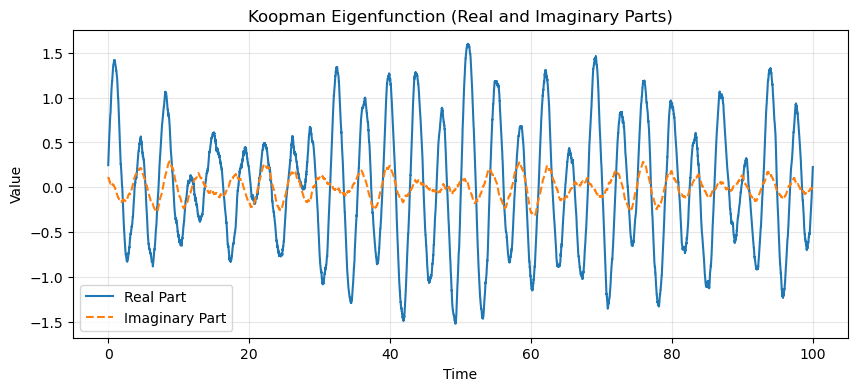

In [437]:
phi_to_plot = phi[0, :] # 选择第一个特征函数

plt.figure(figsize=(10, 4))
plt.title("Koopman Eigenfunction (Real and Imaginary Parts)")
plt.plot(t, np.real(phi_to_plot), label="Real Part")
plt.plot(t, np.imag(phi_to_plot), label="Imaginary Part", linestyle='--')
plt.xlabel("Time")
plt.ylabel("Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

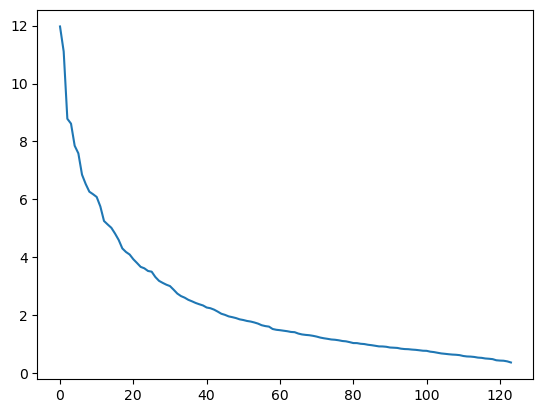

In [410]:
A_ = A @ np.linalg.inv(left_vecs)
U,S,V = np.linalg.svd(A_)
plt.figure()
#plt.plot(np.log(S))
plt.plot(S)
plt.show()

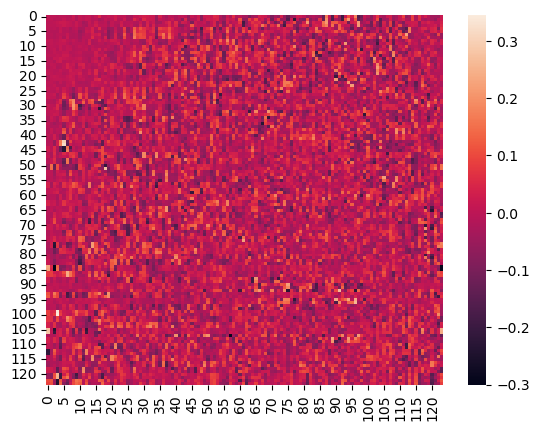

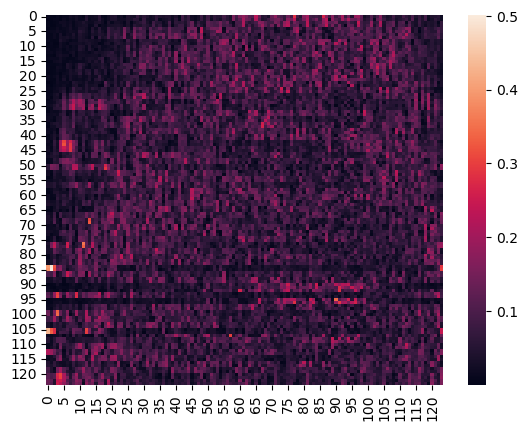

In [330]:
U_abs = np.abs(U)
plt.figure()
sns.heatmap(np.real(U))
plt.show()
plt.figure()
sns.heatmap(U_abs)
plt.show()

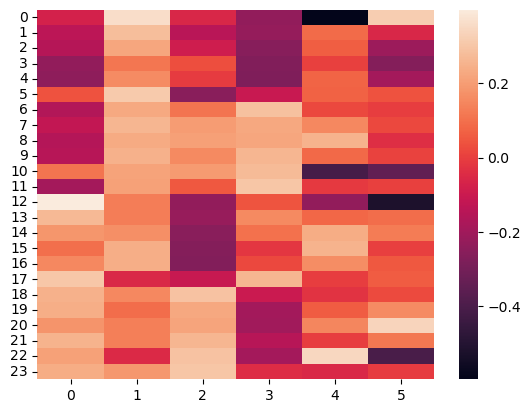

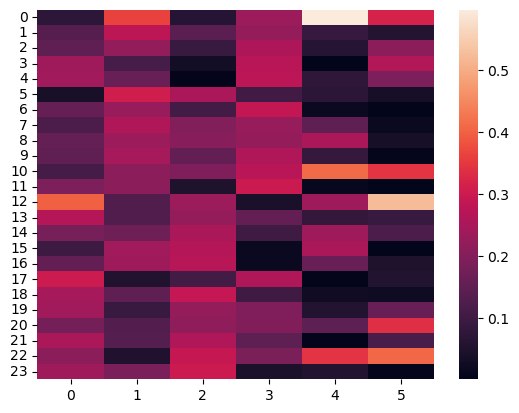

In [280]:
plt.figure()
sns.heatmap(U[:,:6])
plt.show()
plt.figure()
sns.heatmap(U_abs[:,:6])
plt.show()

(<Figure size 640x480 with 3 Axes>,
 array([<Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf U})$'>,
        <Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf A})$'>,
        <Axes: xlabel='$i$', ylabel='$\\sigma_i({\\bf B})$'>], dtype=object))

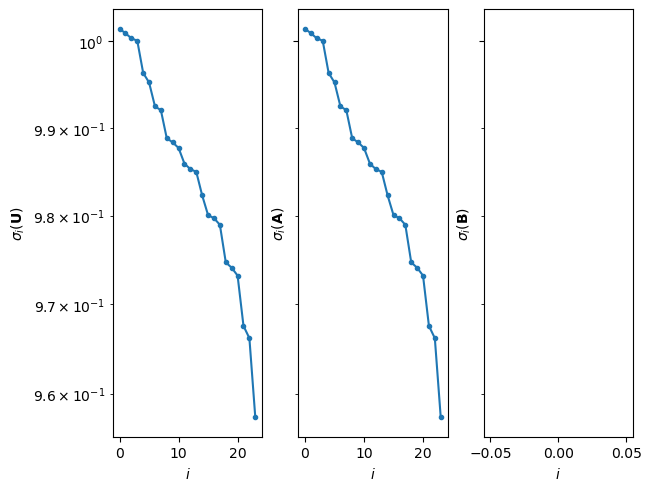

In [386]:
kp.regressor_.plot_svd()

In [128]:
pykoop.lmi_regressors

AttributeError: module 'pykoop' has no attribute 'lmi_regressors'